In [1]:
import sys
import os

# 获取当前工作目录（用于替代 __file__）
current_dir = os.getcwd()

target_path1 = os.path.abspath(os.path.join(current_dir, '../3_move'))
target_path2 = os.path.abspath(os.path.join(current_dir, '../1_getPointCloud'))

# 将路径添加到 sys.path
if target_path1 not in sys.path:
    sys.path.append(target_path1)
    
if target_path2 not in sys.path:
    sys.path.append(target_path2)
    
# 检查路径是否添加成功
print("Current Python Path:")
print("\n".join(sys.path))

from ImageRecognizer import ImageRecognizer
image_recognizer = ImageRecognizer(top_dir="/opt/ros_ws/src/franka_zed_gazebo/scripts/mycode/2_perception/cubes/")


Current Python Path:

/opt/ros_ws/devel/lib/python3/dist-packages
/opt/ros/noetic/lib/python3/dist-packages
/usr/lib/python38.zip
/usr/lib/python3.8
/usr/lib/python3.8/lib-dynload
/usr/local/lib/python3.8/dist-packages
/usr/lib/python3/dist-packages
/opt/ros_ws/src/franka_zed_gazebo/scripts/mycode/3_move
/opt/ros_ws/src/franka_zed_gazebo/scripts/mycode/1_getPointCloud


In [2]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def matrix_to_rpy_and_translation(matrix):
    """
    从4x4变换矩阵中提取RPY（Roll, Pitch, Yaw）和位移信息，并返回一个列表形式。
    
    参数:
        matrix: 4x4变换矩阵 (numpy.ndarray)
        
    返回:
        result: 一个包含 [roll, pitch, yaw, x, y, z] 的列表
    """
    if matrix.shape != (4, 4):
        raise ValueError("输入必须是一个 4x4 矩阵")
    
    # 提取旋转矩阵和位移
    rotation_matrix = matrix[:3, :3]
    translation = matrix[:3, 3]
    
    # 创建旋转矩阵的副本，避免只读内存问题
    rotation_matrix = np.array(rotation_matrix)
    
    # 使用scipy转换为RPY角
    r = R.from_matrix(rotation_matrix)
    roll, pitch, yaw = r.as_euler('xyz', degrees=False)
    
    # 返回结果
    return [roll, pitch, yaw], translation.tolist()


In [3]:
from save_point_cloud import PointCloudSaver
import open3d as o3d
import rospy
point_cloud_saver = PointCloudSaver()

# 等待数据准备
rospy.loginfo("Waiting for data...")
rospy.sleep(1)  # 等待话题数据发布

# 保存点云
original_file = "/opt/ros_ws/zed_point_cloud3.ply"
world_file = "/opt/ros_ws/src/franka_zed_gazebo/scripts/mycode/2_perception/mesh/zed_point_cloud_world3.ply"
point_cloud_saver.save_point_clouds(original_file, world_file)


from PickAndPlace import PickAndPlace
pick_place = PickAndPlace(approach_distance=0.3)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[INFO] [1734647961.190001, 0.000000]: Waiting for data...
[INFO] [1734647966.857233, 675.593000]: Original point cloud saved to /opt/ros_ws/zed_point_cloud3.ply
[INFO] [1734647966.858041, 675.594000]: Requesting transform from world to left_camera_link_optical...
[INFO] [1734647966.858652, 675.594000]: Transform found: header: 
  seq: 0
  stamp: 
    secs: 675
    nsecs: 567000000
  frame_id: "world"
child_frame_id: "left_camera_link_optical"
transform: 
  translation: 
    x: 0.20793722991614136
    y: -0.06183628424145496
    z: 0.5614181126361377
  rotation: 
    x: 0.6592083857263864
    y: 0.6593844938042684
    z: 0.25567074977809545
    w: 0.2555168511593837
[INFO] [1734647966.922562, 675.659000]: Transformed point cloud saved to /opt/ros_ws/src/franka_zed_gazebo/scripts/mycode/2_perception/mesh/zed_point_cloud_w

[ WARN] [1734647967.024913400]: Link zed2_holder has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.


[INFO] [1734647968.204784, 675.733000]: MoveRobot initialized successfully.
[INFO] [1734647968.220813, 676.955000]: Waiting for gripper action servers...
[INFO] [1734647968.524303, 677.260000]: Gripper action servers ready.


In [4]:
import open3d as o3d
import numpy as np

def filter_point_cloud_by_depth(point_cloud, depth_threshold=0.005):
    """
    读取点云文件并过滤掉深度低于指定阈值的点。

    Args:
        ply_path (str): 点云文件的路径。
        depth_threshold (float): 深度阈值，低于该值的点将被过滤。

    Returns:
        o3d.geometry.PointCloud: 过滤后的点云对象。
    """


    # 获取点云的点坐标
    points = np.asarray(point_cloud.points)

    # 过滤深度小于阈值的点
    filtered_points = points[points[:, 2] >= depth_threshold]

    # 创建新的点云对象
    filtered_point_cloud = o3d.geometry.PointCloud()
    filtered_point_cloud.points = o3d.utility.Vector3dVector(filtered_points)

    # 保留颜色信息（如果存在）
    if point_cloud.has_colors():
        colors = np.asarray(point_cloud.colors)
        filtered_colors = colors[points[:, 2] >= depth_threshold]
        filtered_point_cloud.colors = o3d.utility.Vector3dVector(filtered_colors)

    return filtered_point_cloud
zed_ply_path = "mesh/zed_point_cloud_world3.ply"

# 读取点云文件
point_cloud = o3d.io.read_point_cloud(zed_ply_path)
if not point_cloud.has_points():
    raise ValueError(f"Failed to read point cloud from {ply_path}")
filtered_point_cloud = filter_point_cloud_by_depth(point_cloud, depth_threshold=0.005)
o3d.visualization.draw_geometries([filtered_point_cloud], window_name="Filtered Point Cloud")

In [5]:
def calculate_max_layer(filtered_point_cloud, layer_height=0.04):
    """
    计算点云的最高层数 (MaxLayer)，基于 z 轴最大值，使用四舍五入计算。

    Args:
        filtered_point_cloud (o3d.geometry.PointCloud): 已过滤的点云对象。
        layer_height (float): 每一层的高度，默认值为 0.04。

    Returns:
        int: 最高层数 (MaxLayer)。
    """
    # 提取点云的 z 轴最大值
    points = np.asarray(filtered_point_cloud.points)
    z_max = np.max(points[:, 2])

    # 计算最高层数，严格四舍五入
    max_layer = int(np.floor(z_max / layer_height + 0.5))

    return max_layer

# 示例调用
max_layer = calculate_max_layer(filtered_point_cloud, layer_height=0.04)
print(f"MaxLayer: {max_layer}")


MaxLayer: 1


In [6]:
import copy

def register_and_filter(pointcloud, mesh, voxel_size=0.01):
    # 确保输入的 mesh 是 TriangleMesh 对象
    if isinstance(mesh, o3d.geometry.TriangleMesh):
        # 转换网格为点云
        mesh_pointcloud = mesh.sample_points_uniformly(number_of_points=1000)
    elif isinstance(mesh, o3d.geometry.PointCloud):
        # 如果已经是点云，直接使用
        mesh_pointcloud = copy.deepcopy(mesh)
    else:
        raise TypeError("Input mesh must be of type o3d.geometry.TriangleMesh or o3d.geometry.PointCloud")

    # 下采样点云并计算法线和特征
    def preprocess_point_cloud(pcd, voxel_size):
        pcd_down = pcd.voxel_down_sample(voxel_size)
        pcd_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*2, max_nn=30))
        pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            pcd_down,
            search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*5, max_nn=100))
        return pcd_down, pcd_fpfh

    # 粗配准
    def execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size):
        distance_threshold = voxel_size * 1.5
        result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
            source_down, target_down, source_fpfh, target_fpfh, True,
            distance_threshold,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
            4,
            [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
             o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
            o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 400))
        return result

    # 精配准
    def refine_registration(source, target, initial_transformation, voxel_size):
        distance_threshold = voxel_size * 1.0
        result = o3d.pipelines.registration.registration_icp(
            source, target, distance_threshold, initial_transformation,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000000)
        )
        return result
    

    # 下采样点云并计算特征
    source_down, source_fpfh = preprocess_point_cloud(mesh_pointcloud, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(pointcloud, voxel_size)

    # 粗配准
    coarse_result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)

    # 精配准
    refined_result = refine_registration(mesh_pointcloud, pointcloud, coarse_result.transformation, voxel_size)
    # print(refined_result)

    # 将网格点云变换到目标点云的空间
    transform = refined_result.transformation
    transformed_mesh_pointcloud = mesh_pointcloud.transform(transform)

    # 创建包围盒裁剪目标点云
    bounding_box = transformed_mesh_pointcloud.get_axis_aligned_bounding_box()

    # 找到位于包围盒内部的点索引
    indices_inside_box = bounding_box.get_point_indices_within_bounding_box(pointcloud.points)

    # 获取位于包围盒外部的点
    indices_outside_box = [i for i in range(len(pointcloud.points)) if i not in indices_inside_box]

    # 创建新的点云
    remaining_pointcloud = pointcloud.select_by_index(indices_outside_box)
    deleted_pointcloud = pointcloud.select_by_index(indices_inside_box)

    return transform, remaining_pointcloud, deleted_pointcloud, refined_result.fitness

In [7]:
# 读取cube
# 定义文件路径
cube_obj_path = "mesh/cube_0.obj"
zed_ply_path = "mesh/zed_point_cloud_world3.ply"

# 读取 cube_0.obj 点云
cube_mesh = o3d.io.read_triangle_mesh(cube_obj_path)
cube_mesh.compute_vertex_normals()  # 计算法线以便更好显示
# cube_point_cloud = cube_mesh.sample_points_uniformly(number_of_points=50000)  # 转为点云
# cube_point_cloud = cube_mesh.sample_points_poisson_disk(number_of_points=1000)

# 去掉cube下半部分，防止z轴翻转
# cube_point_cloud = filter_point_cloud_by_depth(cube_point_cloud, depth_threshold=-0.015)
# o3d.visualization.draw_geometries([cube_point_cloud])


coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.1,  # 坐标轴大小，可以根据需要调整
    origin=[0, 0, 0]  # 坐标轴的原点
)


In [8]:
def check_transform_z_axis_alignment(transform, tolerance=0.1):
    """
    检查 transform 的 Z 轴是否与世界坐标系的 Z 轴平行。
    允许一定的容差范围内，判断是否平行或反向平行。
    参数:
    - transform: 4x4 转换矩阵
    - tolerance: 判断的容差范围，默认 0.1
    返回:
    - True: 如果 Z 轴平行或反向平行
    - False: 如果 Z 轴不平行
    - 修正后的
    """
    z_axis = np.array([0, 0, 1])  # 世界坐标系的 Z 轴
    transform_z_axis = transform[:3, 2]  # 获取 transform 的 Z 轴（即旋转矩阵的第三列）

    # 计算 transform Z 轴与世界坐标系 Z 轴的夹角
    dot_product = np.dot(transform_z_axis, z_axis)
    # 计算夹角的余弦值，如果接近 1 或 -1，表示平行或反向平行
    if np.abs(dot_product) > (1 - tolerance):
        return True
    return False

def align_transform_z_axis(transform):
    """
    如果 transform 的 Z 轴与世界坐标系 Z 轴反向平行，
    则通过绕 X 轴旋转 180 度（np.pi）来翻转 Z 轴方向。
    
    参数:
    - transform: 4x4 转换矩阵
    
    返回:
    - 修正后的 transform 矩阵
    """
    z_axis_world = np.array([0, 0, 1])  # 世界坐标系的 Z 轴
    transform_z_axis = transform[:3, 2]  # 获取 transform 的 Z 轴（旋转矩阵的第三列）

    # 判断 Z 轴是否与世界坐标系 Z 轴反向平行
    if np.dot(transform_z_axis, z_axis_world) < 0:  # Z 轴反向
        print("修正z轴")
        # 创建绕 X 轴旋转 180 度的旋转矩阵
        rotation_matrix = np.eye(4)
        rotation_matrix[1, 1] = -1  # 旋转矩阵绕 X 轴旋转 180 度
        rotation_matrix[2, 2] = -1  # 旋转矩阵绕 X 轴旋转 180 度
        
        # 进行矩阵乘法，旋转矩阵应用到原始 transform 上
        transform = np.dot(rotation_matrix, transform)

    return transform

In [9]:
import numpy as np
import open3d as o3d
import numpy as np
from scipy.ndimage import gaussian_filter

def max_downsample_image(image, pool_size=(2, 2)):
    """
    使用最大值池化对图像进行降采样。

    Args:
        image (numpy.ndarray): 输入彩色图像 (height, width, 3)
        pool_size (tuple): 池化窗口大小 (height, width)

    Returns:
        downsampled_image (numpy.ndarray): 降采样后的图像
    """
    h, w, c = image.shape
    ph, pw = pool_size

    # 确保图像尺寸是池化窗口的整数倍
    h_new = h // ph * ph
    w_new = w // pw * pw
    image_cropped = image[:h_new, :w_new, :]

    # 使用最大池化降采样
    downsampled_image = image_cropped.reshape(h_new // ph, ph, w_new // pw, pw, c).max(axis=(1, 3))

    return downsampled_image

def pointcloud_to_top_view_image_color(pointcloud, voxel_size=0.01, output_image_size=(512, 512)):
    """
    从点云生成正上方的彩色 2D 图像。
    
    Args:
        pointcloud (o3d.geometry.PointCloud): 输入点云
        voxel_size (float): 分辨率，用于划分网格
        output_image_size (tuple): 输出图像大小 (width, height)
    
    Returns:
        top_view_image (numpy.ndarray): 生成的 2D 彩色图像
    """
    # 获取点云的点坐标和颜色
    points = np.asarray(pointcloud.points)
    colors = np.asarray(pointcloud.colors) if pointcloud.has_colors() else np.zeros_like(points)

    # 提取 x-y 范围
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)
    print(x_max, y_max)

    # 定义网格分辨率
    width, height = output_image_size
    grid_x = np.linspace(x_min, x_max, width)
    grid_y = np.linspace(y_min, y_max, height)

    # 初始化 2D 彩色图像
    top_view_image = np.zeros((height, width, 3))  # RGB 图像

    # 初始化计数矩阵以累积颜色
    count_matrix = np.zeros((height, width))

    # 遍历点云，将每个点投影到网格上
    for point, color in zip(points, colors):
        x, y, z = point
        # 找到对应的网格索引
        x_idx = int((x - x_min) / (x_max - x_min) * (width - 1))
        y_idx = int((y - y_min) / (y_max - y_min) * (height - 1))
        
        # 更新彩色图像和计数矩阵
        top_view_image[height - 1 - y_idx, x_idx] += color  # 累加颜色
        count_matrix[height - 1 - y_idx, x_idx] += 1

    # 平均化颜色值
    nonzero_mask = count_matrix > 0
    top_view_image[nonzero_mask] /= count_matrix[nonzero_mask, None]

    # 将结果归一化到 0-1 范围内
    top_view_image = np.clip(top_view_image, 0, 1)

    return top_view_image


import scipy.ndimage

def interpolate_sparse_image(image, dilation_size=(7, 7)):
    """
    对稀疏的彩色图像进行插值填充。
    
    Args:
        image (numpy.ndarray): 输入彩色图像 (height, width, 3)
        dilation_size (tuple): 膨胀操作的邻域大小 (height, width)
    
    Returns:
        interpolated_image (numpy.ndarray): 插值后的彩色图像
    """
    interpolated_image = image.copy()
    for i in range(3):  # 分别处理 RGB 三个通道
        interpolated_image[:, :, i] = scipy.ndimage.morphology.grey_dilation(
            image[:, :, i], size=dilation_size
        )
    return interpolated_image


def pointcloud_to_colored_image_with_filling(pointcloud, output_size=(512, 512), voxel_size=0.01):
    """
    从点云生成正上方的彩色 2D 图像，使用高斯滤波填充空白区域。
    
    Args:
        pointcloud (o3d.geometry.PointCloud): 输入点云。
        output_size (tuple): 输出图像大小 (width, height)。
        voxel_size (float): 网格分辨率，用于划分网格。
    
    Returns:
        top_view_image (numpy.ndarray): 填充后的彩色图像。
    """
    # 获取点云的点坐标和颜色
    points = np.asarray(pointcloud.points)
    colors = np.asarray(pointcloud.colors) if pointcloud.has_colors() else np.zeros_like(points)

    # 提取 x-y 范围
    x_min, y_min = np.min(points[:, :2], axis=0)
    x_max, y_max = np.max(points[:, :2], axis=0)

    # 定义网格分辨率
    width, height = output_size
    grid_x = np.linspace(x_min, x_max, width)
    grid_y = np.linspace(y_min, y_max, height)

    # 初始化 2D 彩色图像和计数矩阵
    top_view_image = np.zeros((height, width, 3), dtype=np.float32)  # RGB 图像
    count_matrix = np.zeros((height, width), dtype=np.float32)

    # 遍历点云，将每个点投影到网格上
    for point, color in zip(points, colors):
        x, y, z = point
        # 找到对应的网格索引
        x_idx = int((x - x_min) / (x_max - x_min) * (width - 1))
        y_idx = int((y - y_min) / (y_max - y_min) * (height - 1))
        
        # 累积颜色值
        top_view_image[height - 1 - y_idx, x_idx] += color  # 累加颜色
        count_matrix[height - 1 - y_idx, x_idx] += 1

    # 归一化颜色值
    nonzero_mask = count_matrix > 0
    top_view_image[nonzero_mask] /= count_matrix[nonzero_mask, None]

    # 使用高斯滤波填充空白区域
    for channel in range(3):  # 对 R/G/B 通道分别处理
        top_view_image[:, :, channel] = gaussian_filter(top_view_image[:, :, channel], sigma=2)

    # 将图像裁剪到 [0, 1] 范围
    top_view_image = np.clip(top_view_image, 0, 1)

    return top_view_image

def triangle_mesh_to_image(mesh, image_size=(100, 100), fill_radius=1):
    """
    将 TriangleMesh 的顶点投影到 2D 图像上，并通过最大池化生成较小的图像。
    确保每个像素点有值。
    
    Args:
        mesh (o3d.geometry.TriangleMesh): 输入三角网格。
        image_size (tuple): 输出图像大小 (width, height)。
        pool_size (tuple): 池化窗口大小 (height, width)。
        fill_radius (int): 每个点影响的邻域半径（像素）。
    
    Returns:
        numpy.ndarray: 投影后的 2D 图像（池化后大小）。
    """
    # 获取顶点和颜色
    vertices = np.asarray(mesh.vertices)
    colors = np.asarray(mesh.vertex_colors) if mesh.has_vertex_colors() else np.ones((len(vertices), 3))

    # 提取 x-y 范围
    x_min, y_min = vertices[:, 0].min(), vertices[:, 1].min()
    x_max, y_max = vertices[:, 0].max(), vertices[:, 1].max()

    # 初始化 2D 图像
    width, height = image_size
    image = np.zeros((height, width, 3), dtype=np.float32)
    count_matrix = np.zeros((height, width), dtype=np.int32)  # 用于统计像素值累计次数

    # 映射顶点到图像坐标并填充周围像素
    for vertex, color in zip(vertices, colors):
        x, y = vertex[0], vertex[1]
        u = int((x - x_min) / (x_max - x_min) * (width - 1))
        v = int((y - y_min) / (y_max - y_min) * (height - 1))

        # 填充当前点和周围像素
        for du in range(-fill_radius, fill_radius + 1):
            for dv in range(-fill_radius, fill_radius + 1):
                uu = min(max(u + du, 0), width - 1)
                vv = min(max(v + dv, 0), height - 1)
                image[vv, uu] += color
                count_matrix[vv, uu] += 1

    # 平均化每个像素的颜色值
    mask = count_matrix > 0
    image[mask] /= count_matrix[mask, None]

    # 将图像转换为 0-255 的范围
    image = (np.clip(image, 0, 1) * 255).astype(np.uint8)

    return image

def enlarge_points_as_cubes(point_cloud, cube_size=0.0001):
    """
    将点云的每个点替换为一个立方体以增大显示大小。
    
    Args:
        point_cloud (o3d.geometry.PointCloud): 输入点云。
        cube_size (float): 立方体的边长。
    
    Returns:
        o3d.geometry.TriangleMesh: 包含所有点的立方体的组合几何体。
    """
    points = np.asarray(point_cloud.points)
    colors = np.asarray(point_cloud.colors) if point_cloud.has_colors() else [[1, 0, 0]] * len(points)
    mesh = o3d.geometry.TriangleMesh()

    for point, color in zip(points, colors):
        # 创建一个小立方体并移动到点的位置
        cube = o3d.geometry.TriangleMesh.create_box(width=cube_size, height=cube_size, depth=cube_size)
        cube.translate(point - np.array([cube_size / 2, cube_size / 2, cube_size / 2]))
        cube.paint_uniform_color(color)
        mesh += cube  # 将立方体添加到组合网格中

    return mesh


Processing layer 0 (Z range: 0.0050 to 0.0450)
move  1  cube


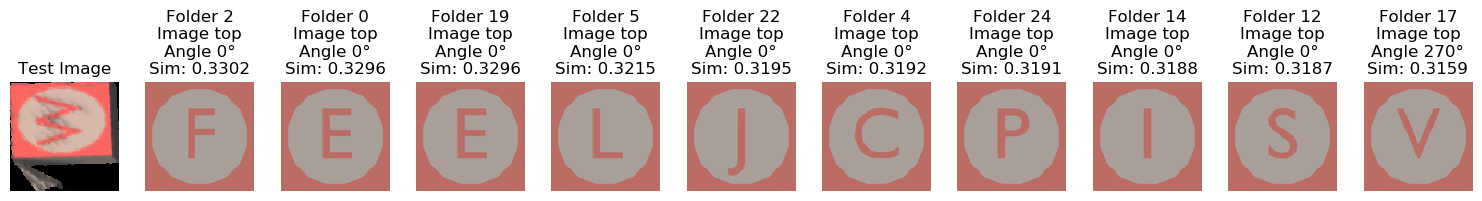

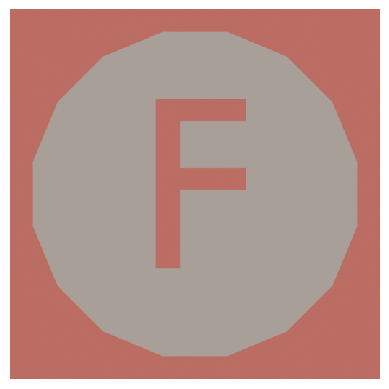

[INFO] [1734647665.295092, 374.137000]: Constraints added: z > 0.01
[INFO] [1734647672.071659, 381.110000]: Path constraints cleared.
[INFO] [1734647672.072611, 381.111000]: Move successful to position: [0.47669000394233746, 0.2811386052323417, 0.5248066551015911] and RPY: [3.0449358002071762, 0.03281878473138833, -1.8655168503619985]
[INFO] [1734647672.073123, 381.111000]: Sending open goal: width: 0.08
speed: 0.1
[INFO] [1734647672.107585, 381.146000]: Gripper opened successfully.
[INFO] [1734647673.128924, 382.148000]: Constraints added: z > 0.01
[INFO] [1734647674.766914, 383.804000]: Path constraints cleared.
[INFO] [1734647674.767710, 383.804000]: Move successful to position: [0.47669000394233746, 0.2811386052323417, 0.43480665510159106] and RPY: [3.0449358002071762, 0.03281878473138833, -1.8655168503619985]
[INFO] [1734647675.268415, 384.305000]: Planning Cartesian path...
[INFO] [1734647675.271922, 384.308000]: Path planning completed successfully!
[INFO] [1734647675.272464, 38

[WARN] [1734647682.008369, 391.043000]: Path planning succeeded for only 0.70% of the path


[INFO] [1734647682.509344, 391.544000]: Sending open goal: width: 0.08
speed: 0.1
[INFO] [1734647683.010643, 392.046000]: Gripper opened successfully.
[INFO] [1734647683.512220, 392.547000]: Planning Cartesian path...


[WARN] [1734647683.519480, 392.554000]: Path planning succeeded for only 0.76% of the path


move  2  cube


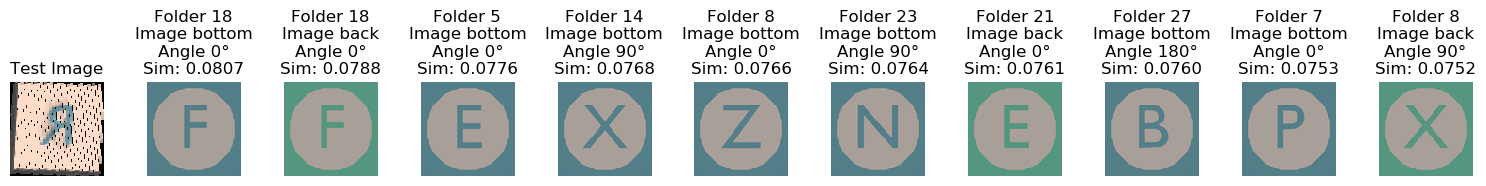

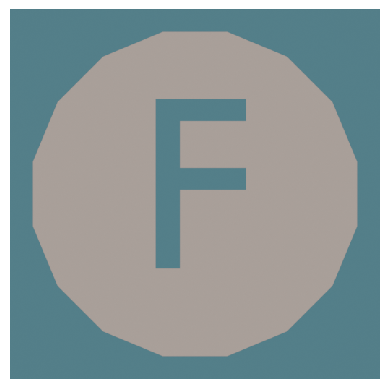

[INFO] [1734647687.832887, 396.836000]: Constraints added: z > 0.01
[INFO] [1734647702.414753, 411.444000]: Path constraints cleared.
[INFO] [1734647702.415721, 411.445000]: Move successful to position: [0.6446363576074375, -0.15511122994125606, 0.5228864425638623] and RPY: [3.06924751897904, -0.02460020098109994, 0.8892352184472768]
[INFO] [1734647702.416181, 411.446000]: Sending open goal: width: 0.08
speed: 0.1
[INFO] [1734647702.450634, 411.480000]: Gripper opened successfully.
[INFO] [1734647703.470518, 412.482000]: Constraints added: z > 0.01
[INFO] [1734647705.177624, 414.207000]: Path constraints cleared.
[INFO] [1734647705.178382, 414.208000]: Move successful to position: [0.6446363576074375, -0.15511122994125606, 0.4328864425638622] and RPY: [3.06924751897904, -0.02460020098109994, 0.8892352184472768]
[INFO] [1734647705.679383, 414.708000]: Planning Cartesian path...
[INFO] [1734647705.682821, 414.712000]: Path planning completed successfully!
[INFO] [1734647705.683231, 414.7

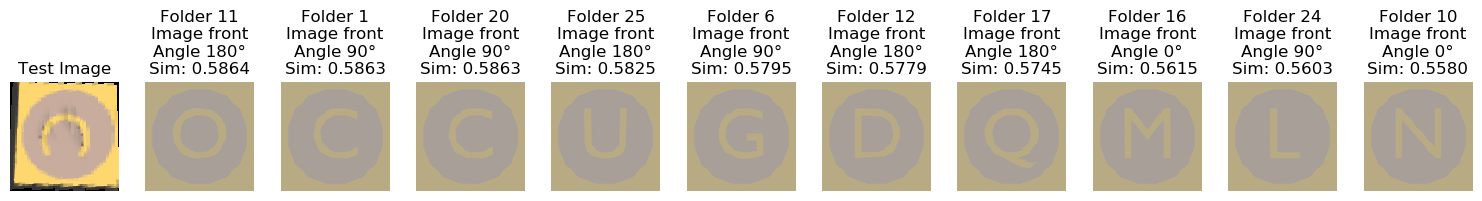

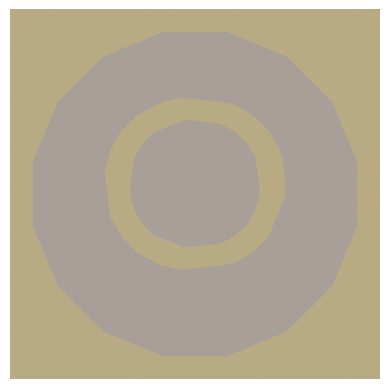

[INFO] [1734647722.542936, 431.545000]: Constraints added: z > 0.01
[INFO] [1734647732.022140, 441.044000]: Path constraints cleared.
[INFO] [1734647732.022942, 441.045000]: Move successful to position: [0.5216762964323511, -0.12403133530311276, 0.5244109644623526] and RPY: [3.064985634508134, -0.028360350620240338, 0.8131985565723998]
[INFO] [1734647732.023321, 441.045000]: Sending open goal: width: 0.08
speed: 0.1
[INFO] [1734647732.057938, 441.080000]: Gripper opened successfully.
[INFO] [1734647733.077578, 442.082000]: Constraints added: z > 0.01
[INFO] [1734647734.755323, 443.777000]: Path constraints cleared.
[INFO] [1734647734.756167, 443.778000]: Move successful to position: [0.5216762964323511, -0.12403133530311276, 0.4344109644623525] and RPY: [3.064985634508134, -0.028360350620240338, 0.8131985565723998]
[INFO] [1734647735.257115, 444.279000]: Planning Cartesian path...
[INFO] [1734647735.260685, 444.283000]: Path planning completed successfully!
[INFO] [1734647735.261080, 4

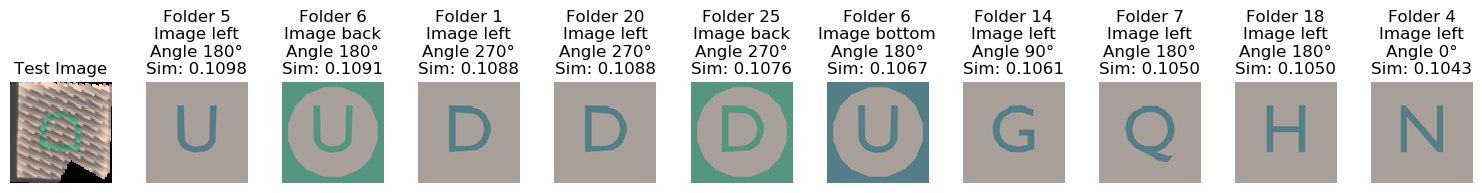

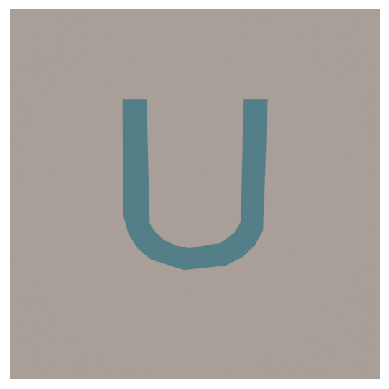

[INFO] [1734647753.549776, 462.549000]: Constraints added: z > 0.01
[INFO] [1734647766.391862, 475.404000]: Path constraints cleared.
[INFO] [1734647766.392685, 475.405000]: Move successful to position: [0.5161652361554688, 0.23620980972250055, 0.5243822011220797] and RPY: [3.109414737089291, -0.05538866542919618, 1.8336425661576101]
[INFO] [1734647766.393123, 475.405000]: Sending open goal: width: 0.08
speed: 0.1
[INFO] [1734647766.427708, 475.440000]: Gripper opened successfully.
[INFO] [1734647767.454786, 476.440000]: Constraints added: z > 0.01
[INFO] [1734647769.032509, 478.044000]: Path constraints cleared.
[INFO] [1734647769.033333, 478.045000]: Move successful to position: [0.5161652361554688, 0.23620980972250055, 0.4343822011220796] and RPY: [3.109414737089291, -0.05538866542919618, 1.8336425661576101]
[INFO] [1734647769.534547, 478.546000]: Planning Cartesian path...
[INFO] [1734647769.538046, 478.550000]: Path planning completed successfully!
[INFO] [1734647769.538487, 478.5

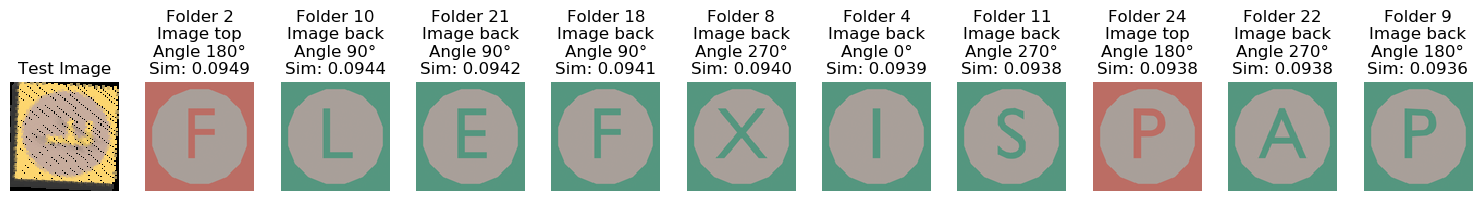

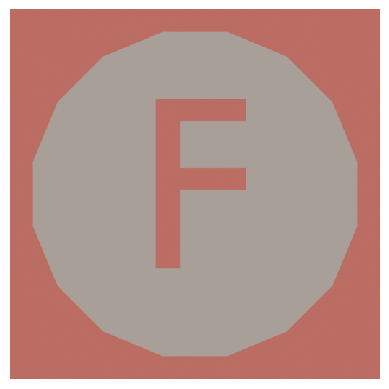

[INFO] [1734647786.727114, 495.713000]: Constraints added: z > 0.01
[INFO] [1734647803.667079, 512.670000]: Path constraints cleared.
[INFO] [1734647803.667969, 512.671000]: Move successful to position: [0.6030777055381444, -0.21817464067197126, 0.5234900027859337] and RPY: [3.0635073033331435, -0.030460332686427893, 1.651936165850616]
[INFO] [1734647803.668451, 512.672000]: Sending open goal: width: 0.08
speed: 0.1
[INFO] [1734647803.702882, 512.706000]: Gripper opened successfully.
[INFO] [1734647804.730818, 513.707000]: Constraints added: z > 0.01
[INFO] [1734647806.368277, 515.370000]: Path constraints cleared.
[INFO] [1734647806.369106, 515.371000]: Move successful to position: [0.6030777055381444, -0.21817464067197126, 0.4334900027859337] and RPY: [3.0635073033331435, -0.030460332686427893, 1.651936165850616]
[INFO] [1734647806.870195, 515.872000]: Planning Cartesian path...
[INFO] [1734647806.873406, 515.875000]: Path planning completed successfully!
[INFO] [1734647806.873765, 5

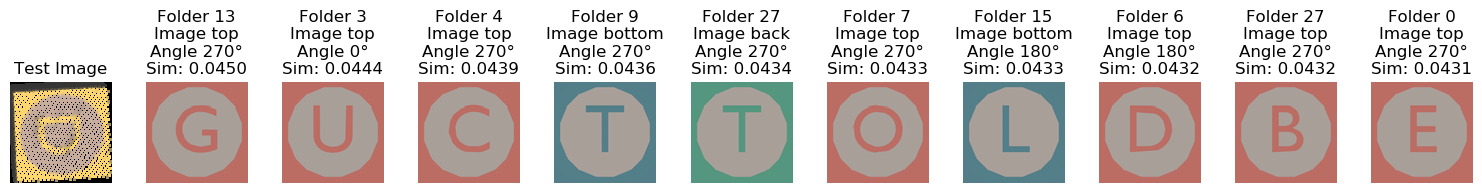

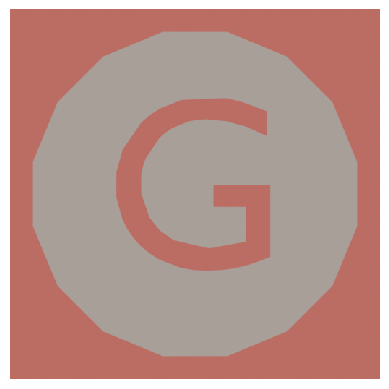

[INFO] [1734647823.337433, 532.303000]: Constraints added: z > 0.01
[INFO] [1734647829.014324, 538.010000]: Path constraints cleared.
[INFO] [1734647829.015207, 538.011000]: Move successful to position: [0.6292475427646976, 0.06296448394606215, 0.5232205836616124] and RPY: [3.2071227034635523, -0.041722138031070166, 0.13211803271901423]
[INFO] [1734647829.015727, 538.012000]: Sending open goal: width: 0.08
speed: 0.1
[INFO] [1734647829.051218, 538.047000]: Gripper opened successfully.
[INFO] [1734647830.070675, 539.048000]: Constraints added: z > 0.01
[INFO] [1734647831.708766, 540.704000]: Path constraints cleared.
[INFO] [1734647831.709593, 540.705000]: Move successful to position: [0.6292475427646976, 0.06296448394606215, 0.43322058366161237] and RPY: [3.2071227034635523, -0.041722138031070166, 0.13211803271901423]
[INFO] [1734647832.210387, 541.205000]: Planning Cartesian path...
[INFO] [1734647832.214063, 541.209000]: Path planning completed successfully!
[INFO] [1734647832.214602

In [10]:
import logging
import matplotlib.pyplot as plt
import cv2

# 设置日志级别为 WARNING，这样 INFO 级别的日志就不会显示
logging.basicConfig(level=logging.WARNING)

def pointcloud_splite_by_layers(point_cloud, max_layer, layer_thickness=0.04, slice_tolerance=0.005):
    """
    将点云切割成多层，每层0.04个高度，然后依次取每个方块放到固定位置并显示。
    """
    # 获取点和颜色信息直接使用 open3d 的方法
    points = point_cloud.points
    colors = point_cloud.colors if point_cloud.has_colors() else o3d.utility.Vector3dVector([[1, 1, 1]] * len(points))
    movecount = 0
    cube_point_cloud = cube_mesh.sample_points_uniformly(number_of_points=50000) 
    cube_point_cloud = filter_point_cloud_by_depth(cube_point_cloud, depth_threshold=-0.01)
    
    for layer in range(max_layer-1, -1, -1):
        z_base = layer * layer_thickness
        z_min = z_base + slice_tolerance
        z_max = z_base + layer_thickness + slice_tolerance

        # 筛选属于该层的点
        mask = [z_min <= pt[2] <= z_max for pt in points]
        layer_points = [points[i] for i in range(len(points)) if mask[i]]
        layer_colors = [colors[i] for i in range(len(colors)) if mask[i]]

        if len(layer_points) > 0:
            print(f"Processing layer {layer} (Z range: {z_min:.4f} to {z_max:.4f})")
            
            # 创建一个新的点云对象用于显示16
            layer_point_cloud = o3d.geometry.PointCloud()
            layer_point_cloud.points = o3d.utility.Vector3dVector(layer_points)
            layer_point_cloud.colors = o3d.utility.Vector3dVector(layer_colors)
            
            remaining_pointcloud_count = 10000
            countdown = 100
            # 使用 open3d 可视化点云
            # o3d.visualization.draw_geometries([layer_point_cloud], window_name=f"Layer {layer} (Z range: {z_min:.4f} to {z_max:.4f})")
            while remaining_pointcloud_count > 50 and countdown>0:
                
                countdown = countdown - 1
                
                
                transform, remaining_pointcloud, deleted_pointcloud, fitness = register_and_filter(layer_point_cloud, cube_point_cloud)
                remaining_pointcloud_count = len(remaining_pointcloud.points)
                # return transform, remaining_pointcloud, deleted_pointcloud
                
                if check_transform_z_axis_alignment(transform) and fitness>0.70 and  np.array_equal(transform, align_transform_z_axis(transform)):
                    print("move ", movecount+1, " cube")
                    # 1. 矫正翻转的z轴
                    
                    # 2. 识别识别出的cube的top面是什么
                    cube_point_cloud_transormed = copy.deepcopy(deleted_pointcloud)
                    cube_point_cloud_transormed = cube_point_cloud_transormed.transform(np.linalg.inv(transform))
                    
                    # cube_point_cloud_transormed = enlarge_points_as_cubes(cube_point_cloud_transormed)
                    # return cube_point_cloud_transormed
                    # return cube_point_cloud_transormed
                    
                    cube_point_cloud_transormed_cubes = enlarge_points_as_cubes(cube_point_cloud_transormed)

                    cube_top_image = triangle_mesh_to_image(cube_point_cloud_transormed_cubes, image_size=(100, 100))
                    
                    # cube_top_image = pointcloud_to_top_view_image_color(cube_point_cloud_transormed)
                    # cube_top_image = max_downsample_image(cube_top_image, pool_size=(16, 16))
                    # cube_top_image = interpolate_sparse_image(cube_top_image, dilation_size=(2, 2))
                    # cube_top_image = max_downsample_image(cube_top_image, pool_size=(3, 3))
                    # cube_top_image = max_downsample_image(cube_top_image, pool_size=(2, 2))
                    
                    cube_top_image = (cube_top_image / cube_top_image.max() * 255).astype(np.uint8)
                    # cube_top_image = point_cloud_to_image(cube_point_cloud_transormed)
                    plt.imsave(f"test_{movecount}.png", cube_top_image)
                    # image_recognizer_result = image_recognizer.recognize_image(cube_top_image)
                    # image_recognizer_result = image_recognizer.match_features_with_orb(cube_top_image)
                    image_recognizer_result = image_recognizer.recognize_image(cube_top_image)
                    image_recognizer.display_results(cube_top_image, image_recognizer_result)
                    # return cube_top_image, image_recognizer_result
                    image_recognizer_best_result = image_recognizer.selected_best_based_on_CNN(image_recognizer_result, cube_top_image)
                    img, angle = image_recognizer.get_image_from_result(image_recognizer_best_result) # angle用于在place时候将其转正
                    plt.imshow(img)
                    plt.axis("off")
                    plt.show()
                    
                    layer_point_cloud = remaining_pointcloud
                    
                    # continue
                    
                    # 3. move 
#                     # 如果匹配度高，则移动将其移动到指定位置6
                    pick_rpy, pick_pos = matrix_to_rpy_and_translation(transform)
#                     pick_rpy = [0, np.pi, pick_rpy[2]]
                    # pick_pos_ = [a + b for a, b in zip(pick_pos, [0.00, 0.025, 0.11])]
                    pick_pos_ = [a + b for a, b in zip(pick_pos, [0.014, 0.020, 0.51])] # 安全距离
                    pick_rpy = [a + b for a, b in zip(pick_rpy, [np.pi, 0, np.pi/4])]
                    pick_place.move(pick_pos_, pick_rpy)
            
                    pick_pos_ = [a + b for a, b in zip(pick_pos, [0.014, 0.020, 0.12])] # 安全距离
                    place_pos = [0.5-0.1*(movecount%4), 0.4-0.1*(movecount//4), 0.15]
                    # print(place_pos)
                    place_rpy = [0, np.pi, -np.pi/4+angle]
#                     pick_rpy = place_rpy
#                     place_pos = [0.6 - (movecount%6)*0.1, 0.5-0.05*(movecount//6), 0.13]
#                     place_pos = pick_pos_
#                     print(place_pos)
                    
                    pick_place.pick_and_place(
                        pick_pos=pick_pos_,
                        pick_rpy=pick_rpy,
                        place_pos=place_pos,
                        place_rpy=place_rpy
                    )
                    # pick_place.move(pick_pos_, pick_rpy)
                    # return transform, remaining_pointcloud, deleted_pointcloud
                    # pick_pos_ = [a + b for a, b in zip(pick_pos, [0.015, 0.020, 0.21])] # 安全距离
        
                    # pick_place.move(pick_pos_, pick_rpy)
                    
                    # pick_pos_ = [a + b for a, b in zip(pick_pos, [0.015, 0.020, 0.51])] # 安全距离
                    
                    # 保持一个安全距离，或者做collision avoidance
                    # pick_place.move(pick_pos_, pick_rpy)
                    movecount = movecount+1
                else:
                    cube_point_cloud = cube_mesh.sample_points_uniformly(number_of_points=50000) 
                    cube_point_cloud = filter_point_cloud_by_depth(cube_point_cloud, depth_threshold=-0.01)
                
            # 这里debug用，直接return
            # return transform, remaining_pointcloud, deleted_pointcloud
    print("done!") 
# T, remaining_pointcloud, deleted_pointcloud = pointcloud_splite_by_layers(filtered_point_cloud, max_layer)
# cube_top_image, image_recognizer_result = pointcloud_splite_by_layers(filtered_point_cloud, max_layer)
# cube_point_cloud_transormed = pointcloud_splite_by_layers(filtered_point_cloud, max_layer)
pointcloud_splite_by_layers(filtered_point_cloud, max_layer)

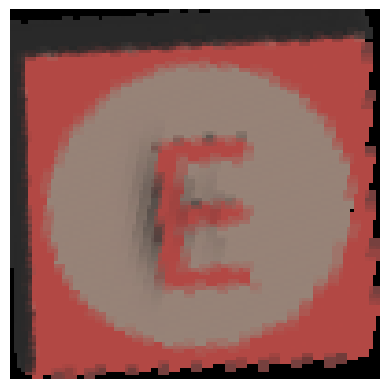

(100, 100, 3)

In [47]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

def triangle_mesh_to_image(mesh, image_size=(400, 400), fill_radius=1):
    """
    将 TriangleMesh 的顶点投影到 2D 图像上，并通过最大池化生成较小的图像。
    确保每个像素点有值。
    
    Args:
        mesh (o3d.geometry.TriangleMesh): 输入三角网格。
        image_size (tuple): 输出图像大小 (width, height)。
        pool_size (tuple): 池化窗口大小 (height, width)。
        fill_radius (int): 每个点影响的邻域半径（像素）。
    
    Returns:
        numpy.ndarray: 投影后的 2D 图像（池化后大小）。
    """
    # 获取顶点和颜色
    vertices = np.asarray(mesh.vertices)
    colors = np.asarray(mesh.vertex_colors) if mesh.has_vertex_colors() else np.ones((len(vertices), 3))

    # 提取 x-y 范围
    x_min, y_min = vertices[:, 0].min(), vertices[:, 1].min()
    x_max, y_max = vertices[:, 0].max(), vertices[:, 1].max()

    # 初始化 2D 图像
    width, height = image_size
    image = np.zeros((height, width, 3), dtype=np.float32)
    count_matrix = np.zeros((height, width), dtype=np.int32)  # 用于统计像素值累计次数

    # 映射顶点到图像坐标并填充周围像素
    for vertex, color in zip(vertices, colors):
        x, y = vertex[0], vertex[1]
        u = int((x - x_min) / (x_max - x_min) * (width - 1))
        v = int((y - y_min) / (y_max - y_min) * (height - 1))

        # 填充当前点和周围像素
        for du in range(-fill_radius, fill_radius + 1):
            for dv in range(-fill_radius, fill_radius + 1):
                uu = min(max(u + du, 0), width - 1)
                vv = min(max(v + dv, 0), height - 1)
                image[vv, uu] += color
                count_matrix[vv, uu] += 1

    # 平均化每个像素的颜色值
    mask = count_matrix > 0
    image[mask] /= count_matrix[mask, None]

    # 将图像转换为 0-255 的范围
    image = (np.clip(image, 0, 1) * 255).astype(np.uint8)

    return image

def enlarge_points_as_cubes(point_cloud, cube_size=0.0001):
    """
    将点云的每个点替换为一个立方体以增大显示大小。
    
    Args:
        point_cloud (o3d.geometry.PointCloud): 输入点云。
        cube_size (float): 立方体的边长。
    
    Returns:
        o3d.geometry.TriangleMesh: 包含所有点的立方体的组合几何体。
    """
    points = np.asarray(point_cloud.points)
    colors = np.asarray(point_cloud.colors) if point_cloud.has_colors() else [[1, 0, 0]] * len(points)
    mesh = o3d.geometry.TriangleMesh()

    for point, color in zip(points, colors):
        # 创建一个小立方体并移动到点的位置
        cube = o3d.geometry.TriangleMesh.create_box(width=cube_size, height=cube_size, depth=cube_size)
        cube.translate(point - np.array([cube_size / 2, cube_size / 2, cube_size / 2]))
        cube.paint_uniform_color(color)
        mesh += cube  # 将立方体添加到组合网格中

    return mesh

cube_point_cloud_transormed_cubes = enlarge_points_as_cubes(cube_point_cloud_transormed)

# 假设 cube_point_cloud_transormed_cubes 是你的 TriangleMesh
image = triangle_mesh_to_image(cube_point_cloud_transormed_cubes, image_size=(100, 100))

# 显示图像
plt.imshow(image)
plt.axis("off")
plt.show()
image.shape

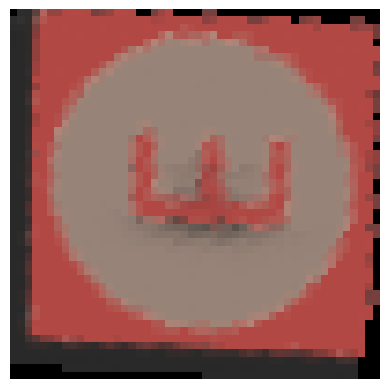

(100, 100, 3)

In [44]:

plt.imshow(max_downsample_image(image, pool_size=(2, 2)))
plt.axis("off")
plt.show()
image.shape

In [53]:
image_recognizer_result[0]

(0.6955262938202064, 0, 'left', 270)

In [ ]:
!pip install opencv-python pytesseract numpy

import cv2
import pytesseract
import numpy as np

# 假设 cube_top_image 是一个包含字符的 numpy 数组
# 这里的 cube_top_image 是示例图像
# cube_top_image = ...

# 使用 pytesseract 识别图像中的字符
def rotate_image(image, angle):
    # 获取图像中心
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    # 计算旋转矩阵
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # 执行旋转
    rotated_image = cv2.warpAffine(image, matrix, (w, h))
    
    return rotated_image

def ocr_recognition(image):
    # 将图像转换为灰度图像
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 使用 pytesseract 识别图像中的文本
    text = pytesseract.image_to_string(gray_image)
    return text

# 假设图像有一个随机角度，你可以通过尝试不同角度来识别文本
angles = [0, 90, 180, 270]  # 你可以尝试不同的旋转角度
recognized_text = None

for angle in angles:
    rotated_image = rotate_image(cube_top_image, angle)
    text = ocr_recognition(rotated_image)
    
    if text.strip():  # 如果识别到文本
        recognized_text = text
        break

print(f"识别到的文本: {recognized_text}")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Do you want to continue? [Y/n] 

In [17]:

T_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.05,  # 坐标轴大小
    origin=[0, 0, 0]  # 原点
)
T_frame.transform(T)
cube_point_cloud_transormed = copy.deepcopy(deleted_pointcloud)
cube_point_cloud_transormed = cube_point_cloud_transormed.transform(np.linalg.inv(T))
o3d.visualization.draw_geometries([deleted_pointcloud, coordinate_frame,  cube_point_cloud_transormed, T_frame])


In [12]:
pick_rpy, pick_pos = matrix_to_rpy_and_translation(T)
pick_pos_ = [a + b for a, b in zip(pick_pos, [0.02, 0.020, 0.21])]
pick_rpy = [a + b for a, b in zip(pick_rpy, [np.pi, 0, np.pi/4])]
# pick_rpy = [a + b for a, b in zip(pick_rpy, [0.00, np.pi, -np.pi/4])]
pick_place.move(pick_pos_, pick_rpy)

[INFO] [1733152459.838289, 6522.737000]: Move successful to position: [0.45739719865225503, 0.09112493338646784, 0.22489037528275815] and RPY: [3.2245424849704794, -0.038469808276325956, 0.5781794040459547]


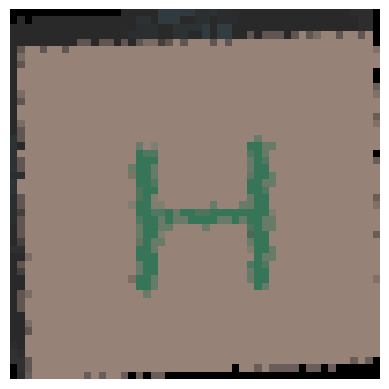

In [30]:
image = point_cloud_to_image(cube_point_cloud_transormed, output_size=(50, 50), point_size=6)

# 使用 Matplotlib 显示图像
plt.imshow(image)
plt.axis('off')  # 关闭坐标轴显示
plt.show()

In [17]:
place_pos = [0.6, 0.5, 0.23]
place_rpy = [0, np.pi, -np.pi/4]
pick_place.move(place_pos, place_rpy)

[INFO] [1733146315.599867, 384.237000]: Move successful to position: [0.6, 0.5, 0.23] and RPY: [0, 3.141592653589793, -0.7853981633974483]


In [34]:
T

array([[-0.06736857, -0.99765115,  0.01239582,  0.5825232 ],
       [-0.99638393,  0.06662791, -0.05272362,  0.28334266],
       [ 0.05177388, -0.01590291, -0.9985322 ,  0.03077611],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [48]:
def find_opposite_axis(T):
    """
    判断哪个轴与 world frame 的 z 轴方向相反。
    
    参数:
    T (numpy.ndarray): 4x4 变换矩阵。
    
    返回:
    str: 'x', 'y', or 'z' 表示哪个轴与 world frame 的 z 轴方向相反。
    """
    # 提取旋转矩阵
    R = T[:3, :3]
    
    # world frame 的 z 轴方向
    world_z = np.array([0, 0, 1])
    
    # 计算各个轴与 world z 轴的点积
    x_axis = R[:, 0]
    y_axis = R[:, 1]
    z_axis = R[:, 2]
    
    # 点积判断：负值表示方向相反，接近 -1 表示完全反向
    dot_products = {
        'x': np.dot(x_axis, world_z),
        'y': np.dot(y_axis, world_z),
        'z': np.dot(z_axis, world_z)
    }
    
    # 找到方向最接近 -1 的轴
    opposite_axis = min(dot_products, key=dot_products.get)
    
    return opposite_axis
opposite_axis = find_opposite_axis(T)
print(f"与 world frame 的 z 轴方向相反的轴是: {opposite_axis}")

def adjust_to_world_z(T):
    """
    调整变换矩阵 T，使与 world frame 的 z 轴方向对齐，同时严格保持右手系特性。
    
    参数:
    T (numpy.ndarray): 4x4 变换矩阵。
    
    返回:
    numpy.ndarray: 调整后的 4x4 变换矩阵。
    """
    
    # 提取旋转矩阵
    R = T[:3, :3]
    
    # world frame 的 z 轴方向
    world_z = np.array([0, 0, 1])
    
    # 各轴方向
    x_axis = R[:, 0]
    y_axis = R[:, 1]
    z_axis = R[:, 2]
    
    # 计算点积，找到与 z 轴方向相反的轴
    dot_products = {
        'x': np.dot(x_axis, world_z),
        'y': np.dot(y_axis, world_z),
        'z': np.dot(z_axis, world_z)
    }
    
    # 找到与 z 轴反向的轴
    opposite_axis = min(dot_products, key=dot_products.get)
    
    # 调整轴方向
    if opposite_axis == 'x':
        new_z = world_z  # z 轴设置为 [0, 0, 1]
        new_y = y_axis   # 保持原来的 y 轴方向
        new_x = np.cross(new_y, new_z)  # 用 y 和 z 计算新的 x
    elif opposite_axis == 'y':
        new_z = world_z  # z 轴设置为 [0, 0, 1]
        new_x = x_axis   # 保持原来的 x 轴方向
        new_y = np.cross(new_z, new_x)  # 用 z 和 x 计算新的 y
    elif opposite_axis == 'z':
        new_z = world_z  # z 轴设置为 [0, 0, 1]
        new_x = x_axis   # 保持原来的 x 轴方向
        new_y = np.cross(new_z, new_x)  # 用 z 和 x 计算新的 y
    
    # 归一化所有轴
    new_x = new_x / np.linalg.norm(new_x)
    new_y = new_y / np.linalg.norm(new_y)
    new_z = new_z / np.linalg.norm(new_z)
    
    # 验证右手性
    R_new = np.column_stack((new_x, new_y, new_z))
    det_R_new = np.linalg.det(R_new)
    if det_R_new < 0:  # 如果不是右手系
        new_y = -new_y  # 反转一个轴方向
        R_new = np.column_stack((new_x, new_y, new_z))
    
    # 构造新的变换矩阵
    T_new = np.eye(4)
    T_new[:3, :3] = R_new
    T_new[:3, 3] = T[:3, 3]  # 保持平移部分不变
    
    return T_new

与 world frame 的 z 轴方向相反的轴是: y


In [64]:
T_new = adjust_to_world_z(T)

In [66]:
T_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.1,  # 坐标轴大小
    origin=[0, 0, 0]  # 原点
)
T_frame.transform(T)
T_new_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.1,  # 坐标轴大小
    origin=[0, 0, 0]  # 原点
)
T_new_frame.transform(T_new)
o3d.visualization.draw_geometries([deleted_pointcloud, coordinate_frame,  T_frame])


In [10]:
matrix_to_rpy_and_translation(T)

([0.03751676351455387, 0.12050001348623428, 1.4494311361457375],
 [0.5439638234072214, 0.1471949043982344, 0.06128015255172841])

[ WARN] [1733100922.529691242]: Link zed2_holder has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.


[INFO] [1733100923.748118, 55.421000]: MoveRobot initialized successfully.
[INFO] [1733100923.762388, 56.682000]: Waiting for gripper action servers...
[INFO] [1733100924.085310, 57.005000]: Gripper action servers ready.


In [12]:
pick_rpy, pick_pos = matrix_to_rpy_and_translation(T)
pick_rpy = [0, np.pi, pick_rpy[2]]
pick_pos

[0.5439638234072214, 0.1471949043982344, 0.06128015255172841]

In [38]:
pick_pos_ = [a + b for a, b in zip(pick_pos, [0.01, 0.02, 0.10])]
place_rpy = [0, np.pi, np.pi/4]
pick_rpy = place_rpy
place_pos = [0.6, 0.5, 0.13]


In [39]:
pick_pos_

[0.5539638234072214, 0.1671949043982344, 0.16128015255172842]

In [45]:
pick_pos_, place_pos = [0.6, 0.5, 0.13+0.1], [a + b for a, b in zip(pick_pos, [0.01, 0.02, 0.0])]

In [46]:
pick_place.pick_and_place(
    pick_pos=pick_pos_,
    pick_rpy=pick_rpy,
    place_pos=place_pos,
    place_rpy=place_rpy
)

[INFO] [1733101297.646593, 430.456000]: Sending open goal: width: 0.08
speed: 0.1
[INFO] [1733101297.681474, 430.491000]: Gripper opened successfully.
[INFO] [1733101303.926676, 436.734000]: Move successful to position: [0.6, 0.5, 0.33] and RPY: [0, 3.141592653589793, 0.7853981633974483]
[INFO] [1733101303.927569, 436.735000]: Generated waypoints:
[INFO] [1733101303.928005, 436.736000]: Waypoint 0: Position(0.6, 0.5, 0.33), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [1733101303.928388, 436.736000]: Waypoint 1: Position(0.6, 0.5, 0.329), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [1733101303.928732, 436.736000]: Waypoint 2: Position(0.6, 0.5, 0.328), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [1733101303.929088, 436.737000]: Waypoint 3: Position(0.6, 0.5, 0.327), Orientation(-0.3826834323650898, 0.

[WARN] [1733101306.094735, 438.902000]: Grasp failed.


[INFO] [1733101306.095674, 438.903000]: Generated waypoints:
[INFO] [1733101306.096151, 438.904000]: Waypoint 0: Position(0.6, 0.5, 0.23), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [1733101306.096493, 438.904000]: Waypoint 1: Position(0.6, 0.5, 0.231), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [1733101306.096837, 438.904000]: Waypoint 2: Position(0.6, 0.5, 0.232), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [1733101306.097161, 438.905000]: Waypoint 3: Position(0.6, 0.5, 0.23299999999999998), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [1733101306.097461, 438.905000]: Waypoint 4: Position(0.6, 0.5, 0.23399999999999999), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [173310130

[WARN] [1733101323.033034, 455.835000]: Failed to open gripper.


[INFO] [1733101323.033893, 455.835000]: Generated waypoints:
[INFO] [1733101323.034391, 455.836000]: Waypoint 0: Position(0.5539638234072214, 0.1671949043982344, 0.1112801525517284), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [1733101323.034744, 455.836000]: Waypoint 1: Position(0.5539638234072214, 0.1671949043982344, 0.11228015255172841), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [1733101323.035105, 455.837000]: Waypoint 2: Position(0.5539638234072214, 0.16719490439823437, 0.11328015255172841), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [1733101323.035409, 455.837000]: Waypoint 3: Position(0.5539638234072214, 0.1671949043982344, 0.11428015255172841), Orientation(-0.3826834323650898, 0.9238795325112867, 2.3432602026631493e-17, 5.657130561438501e-17)
[INFO] [1733101323.035705, 455.837000]: Waypoin